# Laborator: Sequence-to-Sequence Learning cu Numere Romane

În această sesiune, vom explora **sequence-to-sequence learning**, un concept fundamental în machine learning folosit pentru transformarea unei secvențe în alta. Exemple de astfel de sarcini includ traducerea textului dintr-o limbă în alta, sumarizarea textului sau chiar convertirea numerelor în echivalentul lor în cifre romane. Acest laborator va oferi o introducere practică în sarcinile de sequence-to-sequence folosind **PyTorch**. Vei învăța cum să:

1. Reprezinți datele ca secvențe (de exemplu, numere și cifre romane)
2. Pregătești un set de date potrivit pentru sequence-to-sequence learning
3. Înțelegi cum diferiți parametri ai arhitecturii **GRU** pot afecta învățarea

### Numerele Romane ca Studiu de Caz

În acest laborator, vom:
- Genera un set de date cu numere și reprezentările lor în cifre romane
- Examina cum această problemă poate fi încadrată ca o sarcină de sequence-to-sequence
- Pregăti datele pentru antrenarea unui model sequence-to-sequence
- Antrena și evalua mai multe arhitecturi bazate pe GRU

#### Ce Trebuie Să Știi

Acest laborator presupune că ai cunoștințe de bază despre:
- Lucrul cu biblioteci precum `torch` (PyTorch) pentru machine learning
- Concepte despre seturi de date și pregătirea datelor

In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np
from torch import optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

### Înțelegerea Setului de Date: Numere în Numere Romane

În această secțiune, pregătim setul de date pentru sarcina noastră de sequence-to-sequence. Scopul este de a crea perechi de intrare (un număr) și ieșire (reprezentarea sa în cifre romane). Aceste perechi vor fi fundamentul pentru antrenarea unui model care poate învăța transformarea.

---

1. **Convertirea Numerelor în Numere Romane**
  - Funcția `to_roman(num)` primește un număr întreg (de exemplu, `58`) și îl convertește în echivalentul său în cifre romane (de exemplu, `LVIII`).
  - Folosește o **mapare a simbolurilor numerelor romane** la valorile lor întregi și construiește iterativ numărul roman prin scăderea celei mai mari valori posibile.

  **Exemplu:**
  - Input: `29`
  - Procesul de Conversie:
    - Scade `10` → Număr roman: `X`
    - Scade `10` → Număr roman: `XX`
    - Scade `9` → Număr roman: `XXIX`
  - Output: `XXIX`

2. **Clasa RomanNumeralDataset**
  - Această clasă generează un set de date cu numere aleatorii într-un interval specificat și le convertește în numere romane.
  - Utilizează clasa `Dataset` din PyTorch, făcând-o ușor de integrat în pipeline-urile de date pentru machine learning.

  **Exemplu:**
  - Dacă intervalul este de la 1 la 20, setul de date ar putea arăta astfel:
    ```
    Input: [1, 4, 12, 19]
    Output: ['I', 'IV', 'XII', 'XIX']
    ```

3. **Atributele Clasei Dataset**
  - `numbers`: O listă de numere întregi generate aleator în intervalul dat.
  - `roman_numerals`: O listă de șiruri de caractere reprezentând numerele romane corespunzătoare, generate folosind funcția `to_roman`.

4. **Accesarea Datelor**
  - Folosind `getitem(idx)`, poți accesa un număr specific și echivalentul său în cifre romane ca tuplu:
    ```
    dataset.getitem(0)  # Exemplu Output: (3, 'III')
    ```

---

#### Parcurgerea Codului

Iată o detaliere pas cu pas a ceea ce face codul:

1. **Inițializarea Setului de Date**:
  - Setul de date este inițializat cu un set dat sau aleator de numere (de exemplu, 5.000 de perechi din intervalul 0-10.000).
  - Exemplu:
    ```python
    dataset = RomanNumeralDataset(numbers=random.choices(list(range(10_000)), k=5_000))
    ```

2. **Generarea Numerelor Aleatoare**:
  - Numerele întregi aleatoare pot fi generate folosind `torch.randint` sau `np.random.randint` sau alte metode, asigurând o distribuție uniformă în interval.
  - Exemplu Output (aleator): `[25, 178, 3, 944]`

3. **Convertirea Numerelor în Numere Romane**:
  - Pentru fiecare număr, `to_roman` îl convertește în numărul său roman.
  - Exemplu:
    ```
    Input: [25, 178, 3, 944]
    Output: ['XXV', 'CLXXVIII', 'III', 'CMXLIV']
    ```

4. **Recuperarea Eșantioanelor de Date**:
  - Setul de date este iterabil, și fiecare element oferă o pereche `(număr, număr roman)`.

In [ ]:


def to_roman(num):
    roman_values = [
        (1000, 'M'),
        (900, 'CM'),
        (500, 'D'),
        (400, 'CD'),
        (100, 'C'),
        (90, 'XC'),
        (50, 'L'),
        (40, 'XL'),
        (10, 'X'),
        (9, 'IX'),
        (5, 'V'),
        (4, 'IV'),
        (1, 'I')
    ]

    roman = ''
    for value, symbol in roman_values:
        while num >= value:
            roman += symbol
            num -= value
    return roman

class RomanNumeralDataset(Dataset):
    def __init__(self, numbers):
        """
        Create a dataset of numbers and their Roman numeral equivalents.
        Args:
            numbers (list): List of numbers to include in the dataset.
        """
        self.numbers = numbers
        self.roman_numerals = [to_roman(n) for n in self.numbers]

    def __len__(self):
        return len(self.numbers)

    def __getitem__(self, idx):
        return self.numbers[idx], self.roman_numerals[idx]

def create_splits(start=1, end=2025, split_ratio=0.8, shuffle=True):
    """
    Create train and test splits for numbers.

    Args:
        start (int): Starting number for the dataset.
        end (int): Ending number for the dataset.
        split_ratio (float): Ratio of data to use for training (default: 0.8).
        shuffle (bool): Whether to shuffle the data before splitting.

    Returns:
        tuple: Training and testing datasets.
    """
    numbers = list(range(start, end + 1))
    if shuffle:
        np.random.shuffle(numbers)
    split_idx = int(len(numbers) * split_ratio)
    train_numbers = numbers[:split_idx]
    test_numbers = numbers[split_idx:]

    train_dataset = RomanNumeralDataset(train_numbers)
    test_dataset = RomanNumeralDataset(test_numbers)

    return train_dataset, test_dataset

### Tokenizarea Numerelor Arabe: Clasa `ArabicNumberTokenizer`

În sarcinile de sequence-to-sequence, datele de intrare și ieșire trebuie transformate într-un format pe care modelele îl pot procesa. Pentru această sarcină, unde intrarea constă în numere arabe (de exemplu, 1234), avem nevoie de un tokenizer pentru a converti aceste numere în secvențe de token-uri.

Clasa `ArabicNumberTokenizer` oferă o modalitate simplă dar eficientă de a tokeniza și detokeniza numere arabe pentru modele de machine learning. Aceasta gestionează:
- **Codificarea numerelor în secvențe de token-uri**, adăugând token-uri speciale pentru sfârșitul secvenței (EOS) și padding.
- **Decodificarea secvențelor de token-uri înapoi în numere** pentru interpretabilitate.

---

#### Caracteristici Cheie ale Tokenizer-ului

1. **Reprezentarea Token-urilor**
  - Fiecare cifră (`0-9`) este mapată la un index unic de token (`0-9`).
  - Token-uri speciale:
    - `<eos>` (End of Sequence): Index token `10`.
    - `<pad>` (Padding): Index token `11`.

2. **Codificarea Numerelor**
  - Convertește un număr într-o secvență de indici de token-uri.
  - Completează numerele cu zerouri în față până la o lungime fixă (`max_digits`) pentru uniformitate.
  - Adaugă token-ul `<eos>` la secvență pentru a semnala sfârșitul.

  **Exemplu:**
  - Input: `123`
  - Procesul de Codificare:
    - Completare până la `4` cifre: `0123`
    - Convertire în token-uri: `[0, 1, 2, 3]`
    - Adăugare token EOS: `[0, 1, 2, 3, 10]`
  - Output: `torch.tensor([0, 1, 2, 3, 10])`

3. **Decodificarea Token-urilor**
  - Convertește o secvență de token-uri înapoi în numărul corespunzător.
  - Oprește decodificarea la token-ul `<eos>` și ignoră token-urile `<pad>`.

  **Exemplu:**
  - Input: `[0, 1, 2, 3, 10, 11]`
  - Procesul de Decodificare:
    - Ignoră padding-ul (`11`).
    - Se oprește la EOS (`10`).
    - Combină cifrele: `0123`
  - Output: `123`

4. **Gestionarea Vocabularului**
  - Tokenizer-ul definește o **dimensiune a vocabularului** de `12` token-uri:
    - `10 cifre` (`0-9`) + `<eos>` + `<pad>`.
  - Oferă metode utilitare pentru obținerea indexului token-urilor `<pad>` și `<eos>`.

In [ ]:
class ArabicNumberTokenizer:
    def __init__(self, max_digits=4):  # 4 digits can handle numbers up to 3999
        self.max_digits = max_digits
        # Add EOS token at index 10, padding at index 11
        self.digit_to_idx = {str(i): i for i in range(10)}
        self.digit_to_idx['<eos>'] = 10
        self.digit_to_idx['<pad>'] = 11
        self.idx_to_digit = {i: str(i) for i in range(10)}
        self.idx_to_digit[10] = '<eos>'
        self.idx_to_digit[11] = '<pad>'

    def encode(self, number):
        """
        1. You need to convert the number to a string of fixed length (use zfill)
        2. Convert each digit to its corresponding token index using digit_to_idx
        3. Don't forget to add the EOS token at the end
        4. Return everything as a PyTorch tensor

        Example:
        Input number: 42
        Padded to 4 digits: "0042"
        Add EOS: ["0", "0", "4", "2", "<eos>"]
        Convert to indices: [0, 0, 4, 2, 10]
        """
        # Convert number to string
        # use zfill to add 0's at the beginning of the string until it reaches `max_digits`
        number_str = str(number).zfill(self.max_digits)

        # Convert each digit to the token idx and add EOS token
        tokens = [self.digit_to_idx[digit] for digit in number_str] + [self.digit_to_idx['<eos>']]
        return torch.tensor(tokens, dtype=torch.long)

    def decode(self, tokens):
        """
        1. Convert each token back to its digit representation using idx_to_digit
        2. Stop when you hit the EOS token
        3. Skip any padding tokens
        4. Join the digits together and convert back to integer

        Example:
        Input tokens: [0, 0, 4, 2, 10, 11, 11]
        Filter special tokens: ["0", "0", "4", "2"]
        Join and convert: "0042" -> 42
        """
        digits = []
        for token in tokens:
            token = token.item()

            if token == self.digit_to_idx['<eos>']:
                break

            if token != self.digit_to_idx['<pad>']:
                digits.append(self.idx_to_digit[token])

        return int(''.join(digits))

    def vocab_size(self):
        return 12  # 0-9 digits plus EOS and padding tokens

    def pad_idx(self):
        return 11

    def eos_idx(self):
        return 10

In [ ]:
def test_arabic_number_tokenizer():
    print("Testing ArabicNumberTokenizer...")
    tokenizer = ArabicNumberTokenizer(max_digits=4)

    # Test encoding
    number = 123
    encoded = tokenizer.encode(number)
    expected_encoded = torch.tensor([0, 1, 2, 3, 10], dtype=torch.long)  # '0123' + <eos>
    assert torch.equal(encoded, expected_encoded), f"Encoding failed: {encoded} != {expected_encoded}"
    print(f"Encode Test Passed: {number} -> {encoded.tolist()}")

    # Test decoding
    decoded = tokenizer.decode(encoded)
    assert decoded == number, f"Decoding failed: {decoded} != {number}"
    print(f"Decode Test Passed: {encoded.tolist()} -> {decoded}")

    # Edge case: maximum digits
    number = 9999
    encoded = tokenizer.encode(number)
    expected_encoded = torch.tensor([9, 9, 9, 9, 10], dtype=torch.long)  # '9999' + <eos>
    assert torch.equal(encoded, expected_encoded), f"Encoding failed: {encoded} != {expected_encoded}"
    decoded = tokenizer.decode(encoded)
    assert decoded == number, f"Decoding failed: {decoded} != {number}"
    print(f"Edge Test Passed: {number} -> {encoded.tolist()} -> {decoded}")

    # Edge case: padding with zeros
    number = 1
    encoded = tokenizer.encode(number)
    expected_encoded = torch.tensor([0, 0, 0, 1, 10], dtype=torch.long)  # '0001' + <eos>
    assert torch.equal(encoded, expected_encoded), f"Encoding failed: {encoded} != {expected_encoded}"
    decoded = tokenizer.decode(encoded)
    assert decoded == number, f"Decoding failed: {decoded} != {number}"
    print(f"Padding Test Passed: {number} -> {encoded.tolist()} -> {decoded}")

test_arabic_number_tokenizer()

Testing ArabicNumberTokenizer...
Encode Test Passed: 123 -> [0, 1, 2, 3, 10]
Decode Test Passed: [0, 1, 2, 3, 10] -> 123
Edge Test Passed: 9999 -> [9, 9, 9, 9, 10] -> 9999
Padding Test Passed: 1 -> [0, 0, 0, 1, 10] -> 1


### Tokenizarea Numerelor Romane: Clasa `RomanNumeralTokenizer`

Când lucrăm cu sarcini de sequence-to-sequence, datele de ieșire trebuie de asemenea tokenizate într-un format pe care modelele de machine learning îl pot procesa. Pentru sarcina noastră, aceasta înseamnă transformarea numerelor romane (de exemplu, `XXI`) în secvențe de token-uri și invers.

Clasa `RomanNumeralTokenizer` este proiectată să gestioneze:
- **Codificarea numerelor romane în secvențe de token-uri**, adăugând token-uri speciale pentru sfârșitul secvenței (EOS) și padding.
- **Decodificarea secvențelor de token-uri înapoi în numere romane**, permițând interpretabilitatea.

---

#### Caracteristici Cheie ale Tokenizer-ului

1. **Reprezentarea Token-urilor**
  - Caracterele numerelor romane (`I`, `V`, `X`, `L`, `C`, `D`, `M`) sunt fiecare mapate la un index unic de token (`0-6`).
  - Token-uri speciale:
    - `<eos>` (End of Sequence): Index token `7`.
    - `<pad>` (Padding): Index token `8`.

2. **Codificarea Numerelor Romane**
  - Convertește șirurile de numere romane în secvențe de indici de token-uri.
  - Adaugă token-ul `<eos>` pentru a semnala sfârșitul secvenței.
  - Completează secvența cu token-uri `<pad>` pentru a asigura o lungime uniformă (`max_length`).

  **Exemplu:**
  - Input: `XII`, `max_length=6`
  - Procesul de Codificare:
    - Convertire în token-uri: `[2, 0, 0]` (corespunzând lui `X`, `I`, `I`)
    - Adăugare token EOS: `[2, 0, 0, 7]`
    - Completare până la lungimea `6`: `[2, 0, 0, 7, 8, 8]`
  - Output: `torch.tensor([2, 0, 0, 7, 8, 8])`

3. **Decodificarea Token-urilor**
  - Convertește secvențele de token-uri înapoi în șiruri de numere romane.
  - Oprește decodificarea la token-ul `<eos>` și sare peste token-urile `<pad>`.

  **Exemplu:**
  - Input: `[2, 0, 0, 7, 8, 8]`
  - Procesul de Decodificare:
    - Ignoră padding-ul (`8`).
    - Se oprește la EOS (`7`).
    - Combină caracterele: `XII`
  - Output: `XII`

4. **Gestionarea Vocabularului**
  - Tokenizer-ul definește o **dimensiune a vocabularului** de `9` token-uri:
    - `7 caractere de numere romane` (`I`, `V`, `X`, `L`, `C`, `D`, `M`) + `<eos>` + `<pad>`.
  - Oferă metode utilitare pentru obținerea indexului token-urilor `<pad>` și `<eos>`.

In [ ]:
class RomanNumeralTokenizer:
    def __init__(self):
        # Add EOS token at index 7, padding at index 8
        self.char_to_idx = {
            'I': 0,
            'V': 1,
            'X': 2,
            'L': 3,
            'C': 4,
            'D': 5,
            'M': 6,
            '<eos>': 7,
            '<pad>': 8
        }
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}


    def encode(self, roman_numeral, max_length):
        """
        Example:
        Input roman_numeral: "XIV"
        Convert to tokens + <eos>: [2, 0, 1, 7]
        Padd seqeunce with <pad>:  [2, 0, 1, 7, 8]
        """
        # Convert characters to indices and add EOS token
        indices = [self.char_to_idx[char] for char in roman_numeral]
        indices.append(self.char_to_idx['<eos>'])

        # Pad sequence with padding token index
        padded = indices + [self.char_to_idx['<pad>']] * (max_length - len(indices))
        return torch.tensor(padded, dtype=torch.long)

    def decode(self, tokens):
        """
        1. Convert each token back to its numeral representation using idx_to_char
        2. Stop when you hit the EOS token
        3. Skip any padding tokens
        4. Join the digits together

        Example:
        Input tokens: [2, 0, 1, 7, 8]
        Filter special tokens: [2, 0, 1, 7]
        Convert and join: XIV
        """
        # Convert indices back to characters until EOS token
        chars = []
        for token in tokens:
            token = token.item()

            if token == self.char_to_idx['<eos>']:
                break

            if token != self.char_to_idx['<pad>']:
                chars.append(self.idx_to_char[token])

        return ''.join(chars)

    def vocab_size(self):
        return len(self.char_to_idx)  # 7 Roman numerals + EOS + padding = 9

    def pad_idx(self):
        return 8

    def eos_idx(self):
        return 7

In [ ]:
def test_roman_numeral_tokenizer():
    print("Testing RomanNumeralTokenizer...")
    tokenizer = RomanNumeralTokenizer()

    # Test encoding
    roman = "XIV"
    max_length = 5
    encoded = tokenizer.encode(roman, max_length)
    expected_encoded = torch.tensor([2, 0, 1, 7, 8], dtype=torch.long)  # 'XIV' + <eos> + <pad>
    assert torch.equal(encoded, expected_encoded), f"Encoding failed: {encoded} != {expected_encoded}"
    print(f"Encode Test Passed: {roman} -> {encoded.tolist()}")

    # Test decoding
    decoded = tokenizer.decode(encoded)
    assert decoded == roman, f"Decoding failed: {decoded} != {roman}"
    print(f"Decode Test Passed: {encoded.tolist()} -> {decoded}")

    # Edge case: short Roman numeral with padding
    roman = "I"
    encoded = tokenizer.encode(roman, max_length)
    expected_encoded = torch.tensor([0, 7, 8, 8, 8], dtype=torch.long)  # 'I' + <eos> + <pad> * 3
    assert torch.equal(encoded, expected_encoded), f"Encoding failed: {encoded} != {expected_encoded}"
    decoded = tokenizer.decode(encoded)
    assert decoded == roman, f"Decoding failed: {decoded} != {roman}"
    print(f"Padding Test Passed: {roman} -> {encoded.tolist()} -> {decoded}")

    # Edge case: full sequence with no padding
    roman = "MMXXV"
    max_length = 6
    encoded = tokenizer.encode(roman, max_length)
    expected_encoded = torch.tensor([6, 6, 2, 2, 1, 7], dtype=torch.long)  # 'MMXXV' + <eos>
    assert torch.equal(encoded, expected_encoded), f"Encoding failed: {encoded} != {expected_encoded}"
    decoded = tokenizer.decode(encoded)
    assert decoded == roman, f"Decoding failed: {decoded} != {roman}"
    print(f"Full Sequence Test Passed: {roman} -> {encoded.tolist()} -> {decoded}")

test_roman_numeral_tokenizer()

Testing RomanNumeralTokenizer...
Encode Test Passed: XIV -> [2, 0, 1, 7, 8]
Decode Test Passed: [2, 0, 1, 7, 8] -> XIV
Padding Test Passed: I -> [0, 7, 8, 8, 8] -> I
Full Sequence Test Passed: MMXXV -> [6, 6, 2, 2, 1, 7] -> MMXXV


### Sequence-to-Sequence Learning: Modelul `NumberEncoderDecoder`

În această secțiune, vom explora în profunzime arhitectura modelului **sequence-to-sequence (seq2seq)** și implementarea sa pentru convertirea numerelor arabe în numere romane. Modelele seq2seq sunt o clasă de rețele neurale proiectate să mapeze o secvență în alta, fiind deosebit de utile pentru sarcini precum traducerea automată, sumarizarea textului și conversia numerelor în reprezentări numerale.

---

#### Cum Funcționează Modelele Sequence-to-Sequence

Modelele seq2seq constau în două componente principale:
1. **Encoder**: Comprimă secvența de intrare într-un vector de context de lungime fixă (o stare ascunsă) care reprezintă semnificația intrării.
2. **Decoder**: Expandează acest vector de context pentru a genera secvența de ieșire pas cu pas.

##### 1. **Encoder**
- Encoder-ul primește secvența de intrare $( \mathbf{x} = (x_1, x_2, \ldots, x_n) )$, unde fiecare $( x_i )$ este un element al secvenței de intrare (de exemplu, cifre arabe).
- Fiecare element de intrare trece printr-un **strat de embedding**, care mapează token-uri discrete în vectori denși, continui:
 $[
 \mathbf{e}_i = \text{Embedding}(x_i)
 ]$
- Aceste embedding-uri sunt procesate de o rețea neurală recurentă (de exemplu, GRU sau LSTM) pentru a genera stări ascunse:
 $[
 \mathbf{h}_t = f_{\text{encoder}}(\mathbf{e}_t, \mathbf{h}_{t-1})
 ]$
 unde $( f_{\text{encoder}} )$ este funcția recurentă, $( \mathbf{e}_t )$ este embedding-ul la momentul $( t )$, și $( \mathbf{h}_{t-1} )$ este starea ascunsă anterioară.
- Starea ascunsă finală a encoder-ului, $( \mathbf{h}_n )$, servește drept **vector de context**, sumarizând întreaga secvență de intrare.

##### 2. **Decoder**
- Decoder-ul generează secvența de ieșire $( \mathbf{y} = (y_1, y_2, \ldots, y_m) )$ câte un token pe rând.
- La fiecare pas $( t )$, decoder-ul:
 1. Transformă în embedding token-ul anterior $( y_{t-1} )$:
    $[
    \mathbf{e}_{t} = \text{Embedding}(y_{t-1})
    ]$
 2. Combină acest embedding cu vectorul de context $( \mathbf{h}_{n} )$ de la encoder și starea ascunsă anterioară a decoder-ului:
    $[
    \mathbf{h}_t = f_{\text{decoder}}(\mathbf{e}_t, \mathbf{h}_{t-1})
    ]$
 3. Proiectează starea ascunsă $( \mathbf{h}_t )$ în spațiul vocabularului de ieșire pentru a prezice următorul token:
    $[
    \mathbf{y}_t = \text{softmax}(\mathbf{W} \cdot \mathbf{h}_t + \mathbf{b})
    ]$
    unde $( \mathbf{W} )$ și $( \mathbf{b} )$ sunt parametri care pot fi învățați.

---

#### Teacher Forcing

În timpul antrenării, decoder-ul poate fie:
- Să folosească **token-ul corect** $( y_{t-1} )$ ca intrare (teacher forcing), sau
- Să folosească **propriul token prezis** $( \hat{y}_{t-1} )$ din pasul anterior ca intrare.

Teacher forcing ajută la stabilizarea antrenării ghidând modelul, dar dependența totală de teacher forcing poate duce la probleme în timpul inferenței, unde nu există valori corecte disponibile.

---

#### Implementarea `NumberEncoderDecoder`

Modelul `NumberEncoderDecoder` este implementat folosind framework-ul seq2seq:

1. **Encoder**:
  - Transformă în embedding token-urile numerelor arabe folosind `nn.Embedding`.
  - Procesează secvența de embedding-uri folosind `nn.GRU` pentru a produce vectorul de context.

2. **Decoder**:
  - Transformă în embedding token-urile numerelor romane țintă.
  - Le procesează pas cu pas folosind un alt `nn.GRU`.
  - Proiectează ieșirile GRU în dimensiunea vocabularului de numere romane folosind `nn.Linear`.

3. **Teacher Forcing**:
  - Un mecanism probabilistic (controlat de `teacher_forcing_ratio`) determină dacă se folosesc token-urile corecte sau predicțiile modelului ca intrări în timpul decodificării.

---

#### Formularea Matematică a Modelului

Fie $( \mathbf{x} = (x_1, x_2, \ldots, x_n) )$ token-urile arabe de intrare și $( \mathbf{y} = (y_1, y_2, \ldots, y_m) )$ token-urile țintă ale numerelor romane.

1. **Encoder**:
  $[
  \mathbf{h}_t^{\text{enc}} = \text{GRU}_{\text{enc}}(\text{Embedding}(x_t), \mathbf{h}_{t-1}^{\text{enc}})
  ]$
  Starea ascunsă finală $( \mathbf{h}_n^{\text{enc}} )$ este transmisă decoder-ului.

2. **Decoder (la fiecare pas)**:
  - Inițializează prima stare ascunsă cu starea finală a encoder-ului:
    $[
    \mathbf{h}_0^{\text{dec}} = \mathbf{h}_n^{\text{enc}}
    ]$
  - Transformă în embedding intrarea decoder-ului:
    $[
    \mathbf{e}_t^{\text{dec}} = \text{Embedding}(y_{t-1})
    ]$
  - Actualizează starea ascunsă a decoder-ului:
    $[
    \mathbf{h}_t^{\text{dec}} = \text{GRU}_{\text{dec}}(\mathbf{e}_t^{\text{dec}}, \mathbf{h}_{t-1}^{\text{dec}})
    ]$
  - Prezice următorul token:
    $[
    \hat{\mathbf{y}}_t = \text{softmax}(\mathbf{W} \cdot \mathbf{h}_t^{\text{dec}} + \mathbf{b})
    ]$

#### Inițializarea Stării Ascunse $( \mathbf{h}_0 )$

V-ați putea întreba cum este inițializată starea ascunsă $( \mathbf{h}_0 )$ a encoder-ului GRU, având în vedere că implementarea nu definește explicit un parametru care poate fi învățat pentru acest scop. GRU-ul PyTorch gestionează inițializarea stării ascunse automat prin inițializarea $( \mathbf{h}_0 )$ cu zerouri. Deși acest lucru ar putea părea prea simplist, este adesea eficient din mai multe motive:

1. **Parametri care Pot Fi Învățați în Porțile GRU**:
  - GRU conține ponderi care pot fi învățate în cadrul porților și transformărilor sale. Acestea permit GRU-ului să transforme inițializarea cu zerouri în reprezentări semnificative chiar de la primul pas temporal.

2. **Embedding-uri Bogate de Intrare**:
  - Stratul de embedding (`arabic_embedding`) oferă reprezentări vectoriale dense, învățate ale token-urilor de intrare. Aceste embedding-uri transportă informații semnificative, permițând GRU-ului să derive rapid stări ascunse semnificative.

3. **Mecanismul Porții de Actualizare**:
  - GRU-urile includ o poartă de actualizare care poate ajusta eficient starea ascunsă bazată pe intrarea și contextul curent. Acest mecanism permite modelului să depășească potențialele limitări ale inițializării cu zerouri.

În practică, această abordare funcționează bine în multe scenarii, inclusiv în arhitectura `NumberEncoderDecoder`. Cu toate acestea, dacă este necesar, strategii personalizate de inițializare (de exemplu, stări inițiale care pot fi învățate) pot fi adăugate pentru sarcini sau seturi de date specifice.

### Completarea Implementării Modelului `NumberEncoderDecoder`

În această parte, veți completa secțiunile marcate cu `TODO` din modelul `NumberEncoderDecoder`. Aceste `TODO`-uri sunt concepute pentru a vă ghida prin implementarea unui model sequence-to-sequence pentru conversia numerelor arabe în numere romane.

---

#### De Rezolvat

1. **Inițializarea Intrării Decoder-ului**:
  - În metoda `forward`, înlocuiți `TODO` pentru a inițializa intrarea decoder-ului cu primul token din secvența țintă (`tgt`).

2. **Transformarea în Embedding a Intrării Decoder-ului**:
  - În bucla de decodificare din metoda `forward`, înlocuiți `TODO` pentru a transforma în embedding intrarea decoder-ului folosind stratul de embedding pentru numerele romane (`self.roman_embedding`).

3. **Decodificarea Un Pas**:
  - Înlocuiți `TODO` pentru a efectua un pas de decodificare folosind decoder-ul GRU (`self.decoder`).

4. **Proiecția la Dimensiunea Vocabularului**:
  - Înlocuiți `TODO` pentru a mapa ieșirea GRU la dimensiunea vocabularului de numere romane folosind stratul de proiecție de ieșire (`self.output_layer`).

5. **Stocarea Predicțiilor**:
  - Înlocuiți `TODO` pentru a salva predicțiile în tensorul `decoder_outputs`.

6. **Implementarea Teacher Forcing**:
  - Înlocuiți `TODO` în secțiunea de teacher forcing pentru a decide următoarea `decoder_input`:
    - Cu o probabilitate controlată de `teacher_forcing_ratio`, folosiți următorul token din `tgt`.
    - În caz contrar, folosiți token-ul prezis de model.

7. **Generarea Token-urilor Fără Teacher Forcing**:
  - În metoda `generate`:
    - Înlocuiți `TODO` pentru a efectua decodificarea folosind `decode_step`.
    - Înlocuiți `TODO` pentru a actualiza `decoder_input` cu token-ul prezis.
    - Înlocuiți `TODO` pentru a adăuga token-ul prezis în lista `predictions`.
    - Înlocuiți `TODO` pentru a concatena predicțiile într-un tensor la sfârșitul buclei.

In [ ]:
import torch
import torch.nn as nn

class NumberEncoderDecoder(nn.Module):
    def __init__(
        self,
        arabic_vocab_size,
        roman_vocab_size,
        embedding_dim=32,
        hidden_size=128,
        num_layers=1,
        dropout=0.1
    ):
        super().__init__()

        # Get padding indices
        self.arabic_pad_idx = arabic_vocab_size - 1
        self.roman_pad_idx = roman_vocab_size - 1

        # Encoder components
        self.arabic_embedding = nn.Embedding(
            num_embeddings=arabic_vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=self.arabic_pad_idx
        )
        self.encoder = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )

        # Decoder components
        self.roman_embedding = nn.Embedding(
            num_embeddings=roman_vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=self.roman_pad_idx
        )
        self.decoder = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Output projection
        self.output_layer = nn.Linear(hidden_size, roman_vocab_size)

        # Save dimensions
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        """
        src: Tensor of Arabic number tokens [batch_size, src_len]
        tgt: Tensor of Roman numeral tokens [batch_size, tgt_len]
        """
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]

        """
        HINTS for each TODO:

        1. Initialize decoder_input:
        - You need the first token of each sequence in the batch
        - Shape should be [batch_size, 1]


        2. Embed decoder_input:
        - Use self.roman_embedding
        - Make sure input shape matches what embedding layer expects
        - Output should be [batch_size, 1, embedding_dim]

        3. Decode step:
        - Use self.decoder
        - Need both embedded input and previous hidden state
        - Remember that GRU returns (output, hidden_state)

        4. Project to vocabulary size:
        - Use self.output_layer
        - May need to adjust dimensions before projection
        - Output should have scores for each possible token

        5. Store prediction:
        - Save at the correct time step in decoder_outputs
        - Watch dimensions, especially the time dimension

        6. Teacher forcing:
        - When using ground truth: take next token from tgt sequence
        - Shape should match decoder_input's expected shape [batch_size, 1]

        7. Without teacher forcing:
        - Use the model's prediction
        - Convert logits to token indices using argmax
        - Reshape to match decoder_input's expected shape
        """

        # Encode
        src_embedded = self.arabic_embedding(src)
        encoder_outputs, hidden = self.encoder(src_embedded)

        # TODO 1.1: Initialize decoder input with start token (can be the first target token)
        # decoder_input = ...  # Shape: [batch_size, 1]
        decoder_input = tgt[:, 0].unsqueeze(1)

        # Prepare tensor for all decoder outputs
        decoder_outputs = torch.zeros(
            batch_size,
            tgt_len,
            self.output_layer.out_features,
            device=src.device
        )

        # Decode one step at a time
        for t in range(tgt_len):
            # TODO 1.2: Embed decoder input
            # decoder_embedded = ...
            decoder_embedded = self.roman_embedding(decoder_input)
            # TODO 1.3: Decode one step
            # output, hidden = ...
            output, hidden = self.decoder(decoder_embedded, hidden)
            # TODO 1.4: Project to vocabulary size
            # prediction = ...
            prediction = self.output_layer(output)
            # TODO 1.5: Save prediction
            # decoder_outputs[:, t:t+1] = ...
            decoder_outputs[:, t:t+1] = prediction
            # Teacher forcing: use real target tokens as next input
            #
            # with probability teacher_forcing_ratio
            if t < tgt_len - 1:
                if torch.rand(1).item() < teacher_forcing_ratio or not self.training:
                    # TODO 1.6: Use next token from tgt sequence
                    # decoder_input = ...
                    decoder_input = tgt[:, t + 1].unsqueeze(1)
                else:
                    # TODO 1.7: Use our prediction
                    # decoder_input = ...
                    decoder_input = prediction.argmax(dim=-1)

        return decoder_outputs

    def encode(self, src):
        """Encode source sequence to hidden state"""
        src_embedded = self.arabic_embedding(src)
        _, hidden = self.encoder(src_embedded)
        return hidden

    def decode_step(self, decoder_input, hidden):
        """Perform one decoder step"""
        decoder_embedded = self.roman_embedding(decoder_input)
        output, hidden = self.decoder(decoder_embedded, hidden)
        prediction = self.output_layer(output)
        return prediction, hidden

    def generate(self, src, max_length=20):
        """Generate sequence without teacher forcing"""
        batch_size = src.shape[0]

        """
        HINTS for each TODO:

        1. Get prediction and hidden state:
        - Use self.decode_step
        - Pass in current decoder_input and hidden state
        - Returns prediction logits and new hidden state

        2. Update decoder_input:
        - Convert prediction logits to token indices
        - Shape should be [batch_size, 1]

        3. Save prediction:
        - Add current prediction to predictions list
        - No need to modify shape here

        4. Concatenate predictions:
        - Use torch.cat on the predictions list
        - Concatenate along the sequence dimension (dim=1)
        """

        # Encode
        hidden = self.encode(src)

        # Initialize decoder input
        decoder_input = torch.zeros(
            (batch_size, 1),
            dtype=torch.long,
            device=src.device
        )

        # Store predictions
        predictions = []

        # Generate tokens until max_length or EOS token
        for _ in range(max_length):
            # TODO 2.1: Get prediction
            # prediction, hidden = ...
            prediction, hidden = self.decode_step(decoder_input, hidden)
            # TODO 2.2: Get most likely token
            # decoder_input = ...
            decoder_input = prediction.argmax(dim=-1)
            # TODO 2.3: Save prediction
            # ...
            predictions.append(decoder_input)
            # Stop if we predict EOS token
            if (decoder_input == self.roman_pad_idx - 1).all():  # EOS is one before PAD
                break

        # TODO 2.4: Concatenate all predictions. Hint: torch.cat
        predictions = torch.cat(predictions, dim=1)
        return predictions  # Default value, to be replaced

In [ ]:
def test_number_encoder_decoder():
    # Define test parameters
    batch_size = 2
    src_len = 4
    tgt_len = 6
    arabic_vocab_size = 12  # Example: digits (0-9) + EOS + PAD
    roman_vocab_size = 10   # Example: I, V, X, L, C, D, M + EOS + PAD

    # Initialize the model
    model = NumberEncoderDecoder(arabic_vocab_size, roman_vocab_size)

    # Generate dummy input and target sequences
    src = torch.randint(0, arabic_vocab_size - 2, (batch_size, src_len))  # Arabic tokens
    tgt = torch.randint(0, roman_vocab_size - 2, (batch_size, tgt_len))   # Roman tokens

    # Perform a forward pass
    outputs = model(src, tgt, teacher_forcing_ratio=0.5)

    # Check the output shape
    expected_shape = (batch_size, tgt_len, roman_vocab_size)
    assert outputs.shape == expected_shape, f"Output shape mismatch. Expected {expected_shape}, got {outputs.shape}"

    # Test the encode method
    hidden = model.encode(src)
    assert hidden.shape == (model.num_layers, batch_size, model.hidden_size), (
        f"Encode hidden shape mismatch. Expected ({model.num_layers}, {batch_size}, {model.hidden_size}), got {hidden.shape}"
    )

    # Test the decode_step method
    decoder_input = tgt[:, 0:1]  # First token of the target
    prediction, _ = model.decode_step(decoder_input, hidden)
    assert prediction.shape == (batch_size, 1, roman_vocab_size), (
        f"Decode step output shape mismatch. Expected ({batch_size}, 1, {roman_vocab_size}), got {prediction.shape}"
    )

    # Test the generate method
    generated = model.generate(src, max_length=8)
    assert generated.shape[0] == batch_size, f"Generated batch size mismatch. Expected {batch_size}, got {generated.shape[0]}"
    assert generated.shape[1] <= 8, f"Generated sequence length exceeds max_length. Expected <= 8, got {generated.shape[1]}"

    print("All tests passed successfully!")

# Run the test
test_number_encoder_decoder()

All tests passed successfully!


### Training and Evaluating Roman Numeral Conversion Models

In this exercise, you will train and evaluate sequence-to-sequence models for converting Arabic numbers into Roman numerals. The provided code includes:

1. **Dataset Preparation**:
   - `create_splits`: Splits the dataset into training and evaluation sets based on a specified ratio. The split can be shuffled for better generalization.

2. **Custom Collate Function**:
   - `collate_fn`: Prepares batches of Arabic numbers and Roman numerals by tokenizing and padding the sequences.

3. **Training Functionality**:
   - `train_epoch`: Performs a single epoch of training and computes the average training loss. You will encounter **TODOs** related to masking non-padding tokens to ensure the loss calculation is accurate.
   - `train_model`: Trains the model over multiple epochs using the provided configuration. The function handles evaluation after each epoch and saves the best-performing model.

4. **Evaluation Functionality**:
   - `evaluate`: Computes both the token-level loss and **full sample accuracy**, ensuring that the entire Roman numeral must be correct for the prediction to count as accurate. You will encounter **TODOs** where specific components need to be completed, such as decoding and loss calculation.

5. **Comparison of Configurations**:
   - Two configurations (`config` and `config_small`) are provided, allowing you to train models with different parameter settings. These configurations include the embedding size, hidden size, number of layers, dropout, and learning rate.

6. **Metric Visualization**:
   - `plot_metrics`: Generates side-by-side visualizations of training and evaluation losses and accuracies for multiple configurations. The lines are color-coded and styled (solid for training metrics, dashed for evaluation metrics) to make comparisons clearer.

---

### Your Tasks

1. **Complete the TODOs in `train_epoch`**:
   - Implement masking to exclude padding tokens from loss calculations.
   - Ensure that the output and target tensors are properly filtered using the `mask`.

2. **Complete the TODOs in `evaluate`**:
   - Decode predictions and targets using the Roman numeral tokenizer.
   - Ensure accurate comparison for full sample accuracy.
   - Implement loss calculation by masking padding tokens, similar to `train_epoch`.

3. **Compare Configurations**:
   - Analyze the difference in training and evaluation metrics between the `config` (base model) and `config_small` (smaller model).
   - Identify which configuration performs better and why. Consider parameters like model size, embedding dimension, and hidden layers.

4. **Analyze Generalization**:
   - Observe how well the models generalize to the evaluation set created using `create_splits`.
   - Reflect on the impact of the 95% split ratio on generalization and how shuffling affects the train-test split.

5. **Experiment with New Configurations**:
   - Modify the configurations (e.g., learning rate, embedding size, or number of layers) and retrain the models.
   - Use `plot_metrics` to compare the results of your custom configurations with the provided ones.

---

### Key Learning Objectives

- Understand how masking is used to exclude padding tokens from loss calculations.
- Learn how to compute full sample accuracy in sequence-to-sequence tasks.
- Gain hands-on experience with training and evaluating models using different configurations.
- Develop intuition about the relationship between model complexity and performance on training and evaluation sets.

Epoch 1/30


Generated: MCCXXXXXIIIIIIIIIIII, Expected: CVI
Generated: MCCCXXXXXIIIIIIIIIII, Expected: MCCXXI
Generated: MMXXXXXIIIIIIIIIIIII, Expected: MDCXIX
Generated: MCCCXXXXXIIIIIIIIIII, Expected: MDCLV
Generated: MCCXXXXXIIIIIIIIIIII, Expected: MXXVIII
Generated: MCCXXXXXIIIIIIIIIIII, Expected: LXXXVI
Generated: MCCXXXXXIIIIIIIIIIII, Expected: MXLII
Train Loss: 1.5490, Eval Loss: 0.9426, Eval Accuracy: 0.0000
Epoch 2/30


Generated: IIIIII, Expected: CVI
Generated: MMXXXIIIIII, Expected: MCCXXI
Generated: MMXXXIIIIII, Expected: MDCXIX
Generated: MMXXXIIIIII, Expected: MDCLV
Generated: MMXXIIIIII, Expected: MXXVIII
Generated: IIIIII, Expected: LXXXVI
Generated: MXXXIIIIII, Expected: MXLII
Train Loss: 1.0186, Eval Loss: 0.5711, Eval Accuracy: 0.0000
Epoch 3/30


Generated: III, Expected: CVI
Generated: MMMXXXIII, Expected: MCCXXI
Generated: MMXXXIII, Expected: MDCXIX
Generated: MMXXXIII, Expected: MDCLV
Generated: MMXXIII, Expected: MXXVIII
Generated: LLIII, Expected: LXXXVI
Generated: MMXXIII, Expected: MXLII
Train Loss: 0.7596, Eval Loss: 0.3148, Eval Accuracy: 0.0000
Epoch 4/30


Generated: IIIII, Expected: CVI
Generated: MMXXXIIIII, Expected: MCCXXI
Generated: MMXXXIIIII, Expected: MDCXIX
Generated: MMXXXIIIII, Expected: MDCLV
Generated: MXXIIIII, Expected: MXXVIII
Generated: LLIIIII, Expected: LXXXVI
Generated: MXXIIIII, Expected: MXLII
Train Loss: 0.6568, Eval Loss: 0.2338, Eval Accuracy: 0.0000
Epoch 5/30


Evaluating:  43%|████▎     | 3/7 [00:00<00:00, 26.07it/s, Batch Loss=0.189]

Generated: IIII, Expected: CVI
Generated: MMDDIII, Expected: MCCXXI
Generated: MMD, Expected: MDCXIX
Generated: MMD, Expected: MDCLV
Generated: LLIIII, Expected: MXXVIII
Generated: LLIIII, Expected: LXXXVI
Generated: MXXIII, Expected: MXLII


Train Loss: 0.6099, Eval Loss: 0.1874, Eval Accuracy: 0.0000
Epoch 6/30


Generated: III, Expected: CVI
Generated: MMDDIII, Expected: MCCXXI
Generated: MMDD, Expected: MDCXIX
Generated: MMDD, Expected: MDCLV
Generated: LLIII, Expected: MXXVIII
Generated: LLIII, Expected: LXXXVI
Generated: MXXIII, Expected: MXLII
Train Loss: 0.5604, Eval Loss: 0.1443, Eval Accuracy: 0.0000
Epoch 7/30


Generated: III, Expected: CVI
Generated: MMDD, Expected: MCCXXI
Generated: MMDD, Expected: MDCXIX
Generated: MMDD, Expected: MDCLV
Generated: LLIII, Expected: MXXVIII
Generated: LLXXII, Expected: LXXXVI
Generated: MXII, Expected: MXLII
Train Loss: 0.5231, Eval Loss: 0.1266, Eval Accuracy: 0.0000
Epoch 8/30


Generated: III, Expected: CVI
Generated: MMDDVV, Expected: MCCXXI
Generated: MMDD, Expected: MDCXIX
Generated: MMDD, Expected: MDCLV
Generated: LLIII, Expected: MXXVIII
Generated: LLXXIII, Expected: LXXXVI
Generated: MXII, Expected: MXLII
Train Loss: 0.4803, Eval Loss: 0.1086, Eval Accuracy: 0.0000
Epoch 9/30


Generated: III, Expected: CVI
Generated: MMDXVII, Expected: MCCXXI
Generated: MMDC, Expected: MDCXIX
Generated: MMDCC, Expected: MDCLV
Generated: LXX, Expected: MXXVIII
Generated: LLXXII, Expected: LXXXVI
Generated: LXII, Expected: MXLII
Train Loss: 0.4869, Eval Loss: 0.1192, Eval Accuracy: 0.0000
Epoch 10/30


Generated: II, Expected: CVI
Generated: MMDDII, Expected: MCCXXI
Generated: MMDC, Expected: MDCXIX
Generated: MMDC, Expected: MDCLV
Generated: LXVII, Expected: MXXVIII
Generated: LXXVII, Expected: LXXXVI
Generated: LXI, Expected: MXLII
Train Loss: 0.4397, Eval Loss: 0.1196, Eval Accuracy: 0.0000
Epoch 11/30


Generated: II, Expected: CVI
Generated: MMCCVI, Expected: MCCXXI
Generated: MMDC, Expected: MDCXIX
Generated: MMDC, Expected: MDCLV
Generated: LXXI, Expected: MXXVIII
Generated: LXXXII, Expected: LXXXVI
Generated: LXI, Expected: MXLII
Train Loss: 0.4101, Eval Loss: 0.1001, Eval Accuracy: 0.0000
Epoch 12/30


Generated: III, Expected: CVI
Generated: MMCCVII, Expected: MCCXXI
Generated: MMDC, Expected: MDCXIX
Generated: MMDC, Expected: MDCLV
Generated: LXX, Expected: MXXVIII
Generated: LXXXII, Expected: LXXXVI
Generated: MXII, Expected: MXLII
Train Loss: 0.3766, Eval Loss: 0.0844, Eval Accuracy: 0.0000
Epoch 13/30


Generated: II, Expected: CVI
Generated: MMCCLI, Expected: MCCXXI
Generated: MMDCII, Expected: MDCXIX
Generated: MMDCII, Expected: MDCLV
Generated: LXXII, Expected: MXXVIII
Generated: LXXXII, Expected: LXXXVI
Generated: LXI, Expected: MXLII
Train Loss: 0.3599, Eval Loss: 0.0683, Eval Accuracy: 0.0000
Epoch 14/30


Generated: III, Expected: CVI
Generated: MMCCVII, Expected: MCCXXI
Generated: MMDCI, Expected: MDCXIX
Generated: MMDCII, Expected: MDCLV
Generated: DXXII, Expected: MXXVIII
Generated: LXXXII, Expected: LXXXVI
Generated: MXII, Expected: MXLII
Train Loss: 0.3152, Eval Loss: 0.0574, Eval Accuracy: 0.0000
Epoch 15/30


Generated: II, Expected: CVI
Generated: MMCCL, Expected: MCCXXI
Generated: MMDCI, Expected: MDCXIX
Generated: MMDCVI, Expected: MDCLV
Generated: LXVIII, Expected: MXXVIII
Generated: DXXXII, Expected: LXXXVI
Generated: LXI, Expected: MXLII
Train Loss: 0.2992, Eval Loss: 0.0467, Eval Accuracy: 0.0000
Epoch 16/30


Generated: II, Expected: CVI
Generated: MCCCVI, Expected: MCCXXI
Generated: MMDCI, Expected: MDCXIX
Generated: MMDCI, Expected: MDCLV
Generated: DXXIII, Expected: MXXVIII
Generated: DXXXVI, Expected: LXXXVI
Generated: DXV, Expected: MXLII
Train Loss: 0.2678, Eval Loss: 0.0429, Eval Accuracy: 0.0000
Epoch 17/30


Generated: DVV, Expected: CVI
Generated: MCCCVI, Expected: MCCXXI
Generated: MMDCVI, Expected: MDCXIX
Generated: MMDCVI, Expected: MDCLV
Generated: DXVIII, Expected: MXXVIII
Generated: DXXXII, Expected: LXXXVI
Generated: DXVI, Expected: MXLII
Train Loss: 0.2420, Eval Loss: 0.0292, Eval Accuracy: 0.0000
Epoch 18/30


Generated: DVV, Expected: CVI
Generated: MCCCV, Expected: MCCXXI
Generated: MMCCI, Expected: MDCXIX
Generated: MDDCI, Expected: MDCLV
Generated: DXVIII, Expected: MXXVIII
Generated: DXXXV, Expected: LXXXVI
Generated: DXII, Expected: MXLII
Train Loss: 0.2187, Eval Loss: 0.0435, Eval Accuracy: 0.0000
Epoch 19/30


Generated: II, Expected: CVI
Generated: MCCCL, Expected: MCCXXI
Generated: MMCCI, Expected: MDCXIX
Generated: MMDCI, Expected: MDCLV
Generated: DXXIII, Expected: MXXVIII
Generated: DXXXV, Expected: LXXXVI
Generated: DXVV, Expected: MXLII
Train Loss: 0.1792, Eval Loss: 0.0194, Eval Accuracy: 0.0000
Epoch 20/30


Generated: II, Expected: CVI
Generated: MCCCLI, Expected: MCCXXI
Generated: MMCCV, Expected: MDCXIX
Generated: MMDCV, Expected: MDCLV
Generated: DXVIII, Expected: MXXVIII
Generated: DXXXVI, Expected: LXXXVI
Generated: DXII, Expected: MXLII
Train Loss: 0.1814, Eval Loss: 0.0195, Eval Accuracy: 0.0000
Epoch 21/30


Generated: DV, Expected: CVI
Generated: MCCCL, Expected: MCCXXI
Generated: MMDCI, Expected: MDCXIX
Generated: MMDCV, Expected: MDCLV
Generated: DXVIII, Expected: MXXVIII
Generated: DXXXI, Expected: LXXXVI
Generated: DXII, Expected: MXLII
Train Loss: 0.1646, Eval Loss: 0.0351, Eval Accuracy: 0.0000
Epoch 22/30


Generated: DVV, Expected: CVI
Generated: MCCCL, Expected: MCCXXI
Generated: MMDCI, Expected: MDCXIX
Generated: MMDCI, Expected: MDCLV
Generated: DXXIII, Expected: MXXVIII
Generated: DXXXVI, Expected: LXXXVI
Generated: DXII, Expected: MXLII
Train Loss: 0.1370, Eval Loss: 0.0142, Eval Accuracy: 0.0000
Epoch 23/30


Generated: II, Expected: CVI
Generated: MCCCL, Expected: MCCXXI
Generated: MMDCI, Expected: MDCXIX
Generated: MMDCV, Expected: MDCLV
Generated: DXVIII, Expected: MXXVIII
Generated: LXXXVV, Expected: LXXXVI
Generated: DXII, Expected: MXLII
Train Loss: 0.1234, Eval Loss: 0.0112, Eval Accuracy: 0.0000
Epoch 24/30


Generated: II, Expected: CVI
Generated: MCCCV, Expected: MCCXXI
Generated: MMDCI, Expected: MDCXIX
Generated: MMDCV, Expected: MDCLV
Generated: DXVIII, Expected: MXXVIII
Generated: DXXXVV, Expected: LXXXVI
Generated: DXII, Expected: MXLII
Train Loss: 0.1082, Eval Loss: 0.0241, Eval Accuracy: 0.0000
Epoch 25/30


Generated: II, Expected: CVI
Generated: MCCCXI, Expected: MCCXXI
Generated: MMDCI, Expected: MDCXIX
Generated: MMDCV, Expected: MDCLV
Generated: DXVIII, Expected: MXXVIII
Generated: LXXXIX, Expected: LXXXVI
Generated: DXII, Expected: MXLII
Train Loss: 0.1039, Eval Loss: 0.0152, Eval Accuracy: 0.0000
Epoch 26/30


Generated: DVV, Expected: CVI
Generated: MCCCXI, Expected: MCCXXI
Generated: MMDCI, Expected: MDCXIX
Generated: MMDCV, Expected: MDCLV
Generated: DXVIII, Expected: MXXVIII
Generated: DXXXVI, Expected: LXXXVI
Generated: DXII, Expected: MXLII
Train Loss: 0.0886, Eval Loss: 0.0091, Eval Accuracy: 0.0000
Epoch 27/30


Generated: DVV, Expected: CVI
Generated: MCCCV, Expected: MCCXXI
Generated: MMCCI, Expected: MDCXIX
Generated: MMDCV, Expected: MDCLV
Generated: DXVIII, Expected: MXXVIII
Generated: DXXXI, Expected: LXXXVI
Generated: DXII, Expected: MXLII
Train Loss: 0.0846, Eval Loss: 0.0126, Eval Accuracy: 0.0000
Epoch 28/30


Generated: DVV, Expected: CVI
Generated: MCCCXI, Expected: MCCXXI
Generated: MMDCI, Expected: MDCXIX
Generated: MMDCV, Expected: MDCLV
Generated: DXVIII, Expected: MXXVIII
Generated: DXXXI, Expected: LXXXVI
Generated: DXII, Expected: MXLII
Train Loss: 0.0777, Eval Loss: 0.0120, Eval Accuracy: 0.0000
Epoch 29/30


Generated: II, Expected: CVI
Generated: MCCCX, Expected: MCCXXI
Generated: MMDCI, Expected: MDCXIX
Generated: MMDCV, Expected: MDCLV
Generated: LXVIII, Expected: MXXVIII
Generated: LXXXV, Expected: LXXXVI
Generated: DXII, Expected: MXLII
Train Loss: 0.0825, Eval Loss: 0.0073, Eval Accuracy: 0.0000
Epoch 30/30


Generated: II, Expected: CVI
Generated: MCCCXI, Expected: MCCXXI
Generated: MMDCI, Expected: MDCXIX
Generated: MMDCV, Expected: MDCLV
Generated: DXVIII, Expected: MXXVIII
Generated: LXXXV, Expected: LXXXVI
Generated: DXII, Expected: MXLII
Train Loss: 0.0841, Eval Loss: 0.0046, Eval Accuracy: 0.0098
Model checkpoint saved!
Epoch 1/30


Generated: DI, Expected: CVI
Generated: MDDII, Expected: MCCXXI
Generated: MDDII, Expected: MDCXIX
Generated: MDDI, Expected: MDCLV
Generated: MDII, Expected: MXXVIII
Generated: CXII, Expected: LXXXVI
Generated: MDII, Expected: MXLII
Train Loss: 1.3049, Eval Loss: 0.8914, Eval Accuracy: 0.0000
Epoch 2/30


Generated: DII, Expected: CVI
Generated: MDDCC, Expected: MCCXXI
Generated: MDDLII, Expected: MDCXIX
Generated: MMDD, Expected: MDCLV
Generated: MDXII, Expected: MXXVIII
Generated: DXXVII, Expected: LXXXVI
Generated: MDIII, Expected: MXLII
Train Loss: 0.8249, Eval Loss: 0.5025, Eval Accuracy: 0.0196
Model checkpoint saved!
Epoch 3/30


Generated: DX, Expected: CVI
Generated: MDDLI, Expected: MCCXXI
Generated: MDDL, Expected: MDCXIX
Generated: MDDC, Expected: MDCLV
Generated: MXXII, Expected: MXXVIII
Generated: DXXII, Expected: LXXXVI
Generated: MXXI, Expected: MXLII
Train Loss: 0.5976, Eval Loss: 0.2832, Eval Accuracy: 0.0000
Epoch 4/30


Generated: III, Expected: CVI
Generated: MCCXX, Expected: MCCXXI
Generated: MCCXX, Expected: MDCXIX
Generated: MDCC, Expected: MDCLV
Generated: MXXIII, Expected: MXXVIII
Generated: DXXXI, Expected: LXXXVI
Generated: MXXI, Expected: MXLII
Train Loss: 0.4855, Eval Loss: 0.1797, Eval Accuracy: 0.0000
Epoch 5/30


Generated: II, Expected: CVI
Generated: MCCXX, Expected: MCCXXI
Generated: MDCCX, Expected: MDCXIX
Generated: MDCC, Expected: MDCLV
Generated: MXXIII, Expected: MXXVIII
Generated: LXXXX, Expected: LXXXVI
Generated: MXXI, Expected: MXLII
Train Loss: 0.4336, Eval Loss: 0.1224, Eval Accuracy: 0.0098
Epoch 6/30


Generated: DXX, Expected: CVI
Generated: MCCCXX, Expected: MCCXXI
Generated: MDCXX, Expected: MDCXIX
Generated: MDCC, Expected: MDCLV
Generated: MXXIII, Expected: MXXVIII
Generated: DXXXI, Expected: LXXXVI
Generated: MXXII, Expected: MXLII
Train Loss: 0.3485, Eval Loss: 0.0693, Eval Accuracy: 0.0196
Epoch 7/30


Generated: DX, Expected: CVI
Generated: MCCXX, Expected: MCCXXI
Generated: MDCXI, Expected: MDCXIX
Generated: MDCC, Expected: MDCLV
Generated: MXXIII, Expected: MXXVIII
Generated: DXXXI, Expected: LXXXVI
Generated: MXCI, Expected: MXLII
Train Loss: 0.2759, Eval Loss: 0.0870, Eval Accuracy: 0.0000
Epoch 8/30


Generated: DI, Expected: CVI
Generated: MCCXXX, Expected: MCCXXI
Generated: MDCXX, Expected: MDCXIX
Generated: MDCC, Expected: MDCLV
Generated: MXCIII, Expected: MXXVIII
Generated: LXXXI, Expected: LXXXVI
Generated: MXCI, Expected: MXLII
Train Loss: 0.2336, Eval Loss: 0.1123, Eval Accuracy: 0.0098
Epoch 9/30


Generated: DI, Expected: CVI
Generated: MCCXX, Expected: MCCXXI
Generated: MDCXX, Expected: MDCXIX
Generated: MDCC, Expected: MDCLV
Generated: MXXIII, Expected: MXXVIII
Generated: LXXXIV, Expected: LXXXVI
Generated: MXCIV, Expected: MXLII
Train Loss: 0.2195, Eval Loss: 0.0371, Eval Accuracy: 0.0000
Epoch 10/30


Evaluating:  57%|█████▋    | 4/7 [00:00<00:00, 30.78it/s, Batch Loss=0.0265]

Generated: II, Expected: CVI
Generated: MCCCX, Expected: MCCXXI
Generated: MDCCC, Expected: MDCXIX
Generated: MDCC, Expected: MDCLV
Generated: MXXVII, Expected: MXXVIII
Generated: LXXXI, Expected: LXXXVI
Generated: MXCIV, Expected: MXLII


Train Loss: 0.1620, Eval Loss: 0.0217, Eval Accuracy: 0.0392
Model checkpoint saved!
Epoch 11/30


Generated: DII, Expected: CVI
Generated: MCCXXX, Expected: MCCXXI
Generated: MDCXX, Expected: MDCXIX
Generated: MDCCX, Expected: MDCLV
Generated: MXXVII, Expected: MXXVIII
Generated: LLXXII, Expected: LXXXVI
Generated: MXCIV, Expected: MXLII
Train Loss: 0.1394, Eval Loss: 0.0158, Eval Accuracy: 0.0686
Model checkpoint saved!
Epoch 12/30


Evaluating:  86%|████████▌ | 6/7 [00:00<00:00, 28.27it/s, Batch Loss=0.00848]

Generated: DII, Expected: CVI
Generated: MCCXX, Expected: MCCXXI
Generated: MDCXC, Expected: MDCXIX
Generated: MDCCX, Expected: MDCLV
Generated: MXXIII, Expected: MXXVIII
Generated: LXXXII, Expected: LXXXVI


Generated: MXCIX, Expected: MXLII
Train Loss: 0.1096, Eval Loss: 0.0117, Eval Accuracy: 0.0784
Model checkpoint saved!
Epoch 13/30


Generated: DI, Expected: CVI
Generated: MCCXXX, Expected: MCCXXI
Generated: MDCXI, Expected: MDCXIX
Generated: MDCC, Expected: MDCLV
Generated: MXXIIII, Expected: MXXVIII
Generated: LXXXXV, Expected: LXXXVI
Generated: MXCIX, Expected: MXLII
Train Loss: 0.1081, Eval Loss: 0.0138, Eval Accuracy: 0.0490
Epoch 14/30


Evaluating:  43%|████▎     | 3/7 [00:00<00:00, 28.51it/s, Batch Loss=0.00757]

Generated: DI, Expected: CVI
Generated: MCCXXX, Expected: MCCXXI
Generated: MDCXC, Expected: MDCXIX
Generated: MDCC, Expected: MDCLV
Generated: MXXIII, Expected: MXXVIII
Generated: LXXXII, Expected: LXXXVI


Generated: MXCIX, Expected: MXLII
Train Loss: 0.0687, Eval Loss: 0.0168, Eval Accuracy: 0.0588
Epoch 15/30


Generated: DII, Expected: CVI
Generated: MCCXXX, Expected: MCCXXI
Generated: MDCXI, Expected: MDCXIX
Generated: MDCC, Expected: MDCLV
Generated: MXXIII, Expected: MXXVIII
Generated: LLXXXI, Expected: LXXXVI
Generated: MXCIV, Expected: MXLII
Train Loss: 0.0738, Eval Loss: 0.0075, Eval Accuracy: 0.0686
Epoch 16/30


Generated: LIV, Expected: CVI
Generated: MCCXXX, Expected: MCCXXI
Generated: MDCXI, Expected: MDCXIX
Generated: MDCC, Expected: MDCLV
Generated: MXXIII, Expected: MXXVIII
Generated: LXXXIV, Expected: LXXXVI
Generated: MXIIV, Expected: MXLII
Train Loss: 0.0619, Eval Loss: 0.0061, Eval Accuracy: 0.0490
Epoch 17/30


Generated: LI, Expected: CVI
Generated: MCCXXX, Expected: MCCXXI
Generated: MDCXI, Expected: MDCXIX
Generated: MDCL, Expected: MDCLV
Generated: MXXIII, Expected: MXXVIII
Generated: LXXXVI, Expected: LXXXVI
Generated: MXII, Expected: MXLII
Train Loss: 0.0519, Eval Loss: 0.0045, Eval Accuracy: 0.1078
Model checkpoint saved!
Epoch 18/30


Generated: DII, Expected: CVI
Generated: MCCXXX, Expected: MCCXXI
Generated: MDCXI, Expected: MDCXIX
Generated: MDCL, Expected: MDCLV
Generated: MXXIII, Expected: MXXVIII
Generated: LXXXVI, Expected: LXXXVI
Generated: MXIII, Expected: MXLII
Train Loss: 0.0404, Eval Loss: 0.0061, Eval Accuracy: 0.1275
Model checkpoint saved!
Epoch 19/30


Generated: LI, Expected: CVI
Generated: MCCXXX, Expected: MCCXXI
Generated: MDCXX, Expected: MDCXIX
Generated: MDCL, Expected: MDCLV
Generated: MXXIII, Expected: MXXVIII
Generated: LXXXII, Expected: LXXXVI
Generated: MXII, Expected: MXLII
Train Loss: 0.0454, Eval Loss: 0.0513, Eval Accuracy: 0.0490
Epoch 20/30


Generated: DII, Expected: CVI
Generated: MCCXXX, Expected: MCCXXI
Generated: MDCXIX, Expected: MDCXIX
Generated: MDCL, Expected: MDCLV
Generated: MXXIIII, Expected: MXXVIII
Generated: LXXXVI, Expected: LXXXVI
Generated: MXIII, Expected: MXLII
Train Loss: 0.0599, Eval Loss: 0.0049, Eval Accuracy: 0.1471
Model checkpoint saved!
Epoch 21/30


Generated: DII, Expected: CVI
Generated: MCCXXI, Expected: MCCXXI
Generated: MDCXI, Expected: MDCXIX
Generated: MDCL, Expected: MDCLV
Generated: MXXIIII, Expected: MXXVIII
Generated: LLXXXI, Expected: LXXXVI
Generated: MXIII, Expected: MXLII
Train Loss: 0.0190, Eval Loss: 0.0025, Eval Accuracy: 0.2255
Model checkpoint saved!
Epoch 22/30


Generated: LI, Expected: CVI
Generated: MCCXX, Expected: MCCXXI
Generated: MDCXI, Expected: MDCXIX
Generated: MDCLL, Expected: MDCLV
Generated: MXXIII, Expected: MXXVIII
Generated: LXXXVI, Expected: LXXXVI
Generated: MXII, Expected: MXLII
Train Loss: 0.0259, Eval Loss: 0.0078, Eval Accuracy: 0.1078
Epoch 23/30


Generated: LI, Expected: CVI
Generated: MCCXXX, Expected: MCCXXI
Generated: MDCXI, Expected: MDCXIX
Generated: MDCL, Expected: MDCLV
Generated: MXXIII, Expected: MXXVIII
Generated: LLXXVI, Expected: LXXXVI
Generated: MXCII, Expected: MXLII
Train Loss: 0.0167, Eval Loss: 0.0014, Eval Accuracy: 0.1961
Epoch 24/30


Generated: LI, Expected: CVI
Generated: MCCXXX, Expected: MCCXXI
Generated: MDCXIX, Expected: MDCXIX
Generated: MDCLV, Expected: MDCLV
Generated: MXXIIII, Expected: MXXVIII
Generated: LXXXVI, Expected: LXXXVI
Generated: MXIII, Expected: MXLII
Train Loss: 0.0207, Eval Loss: 0.0176, Eval Accuracy: 0.2157
Epoch 25/30


Evaluating:  57%|█████▋    | 4/7 [00:00<00:00, 34.57it/s, Batch Loss=0.00453]

Generated: DII, Expected: CVI
Generated: MCCXXX, Expected: MCCXXI
Generated: MDCXIX, Expected: MDCXIX
Generated: MDCL, Expected: MDCLV
Generated: MXXIIII, Expected: MXXVIII
Generated: DLXXXVI, Expected: LXXXVI


Generated: MXIII, Expected: MXLII
Train Loss: 0.0615, Eval Loss: 0.0083, Eval Accuracy: 0.1863
Epoch 26/30


Generated: LII, Expected: CVI
Generated: MCCXXI, Expected: MCCXXI
Generated: MDCXIX, Expected: MDCXIX
Generated: MDCLV, Expected: MDCLV
Generated: MXXIIII, Expected: MXXVIII
Generated: LXXXVI, Expected: LXXXVI
Generated: MXLII, Expected: MXLII
Train Loss: 0.0185, Eval Loss: 0.0014, Eval Accuracy: 0.4706
Model checkpoint saved!
Epoch 27/30


Evaluating:  86%|████████▌ | 6/7 [00:00<00:00, 27.79it/s, Batch Loss=0.000595]

Generated: LI, Expected: CVI
Generated: MCCXXI, Expected: MCCXXI
Generated: MDCXIX, Expected: MDCXIX
Generated: MDCLV, Expected: MDCLV
Generated: MXXIII, Expected: MXXVIII
Generated: LXXXVI, Expected: LXXXVI


Generated: MXIII, Expected: MXLII
Train Loss: 0.0104, Eval Loss: 0.0008, Eval Accuracy: 0.3627
Epoch 28/30


Generated: LI, Expected: CVI
Generated: MCCXXI, Expected: MCCXXI
Generated: MDCXIX, Expected: MDCXIX
Generated: MDCL, Expected: MDCLV
Generated: MXXIII, Expected: MXXVIII
Generated: LXXXVI, Expected: LXXXVI
Generated: MXII, Expected: MXLII
Train Loss: 0.0038, Eval Loss: 0.0006, Eval Accuracy: 0.2647
Epoch 29/30


Generated: LI, Expected: CVI
Generated: MCCXXI, Expected: MCCXXI
Generated: MDCXIX, Expected: MDCXIX
Generated: MDCLV, Expected: MDCLV
Generated: MXXIII, Expected: MXXVIII
Generated: LXXXVI, Expected: LXXXVI
Generated: MXIII, Expected: MXLII
Train Loss: 0.0029, Eval Loss: 0.0006, Eval Accuracy: 0.1863
Epoch 30/30


<ipython-input-44-405475b57cd1>:193: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('Dark2', len(metrics_list))


Generated: LI, Expected: CVI
Generated: MCCXXI, Expected: MCCXXI
Generated: MDCXIX, Expected: MDCXIX
Generated: MDCLV, Expected: MDCLV
Generated: MXXIII, Expected: MXXVIII
Generated: LXXXVI, Expected: LXXXVI
Generated: MXII, Expected: MXLII
Train Loss: 0.0039, Eval Loss: 0.0005, Eval Accuracy: 0.3137


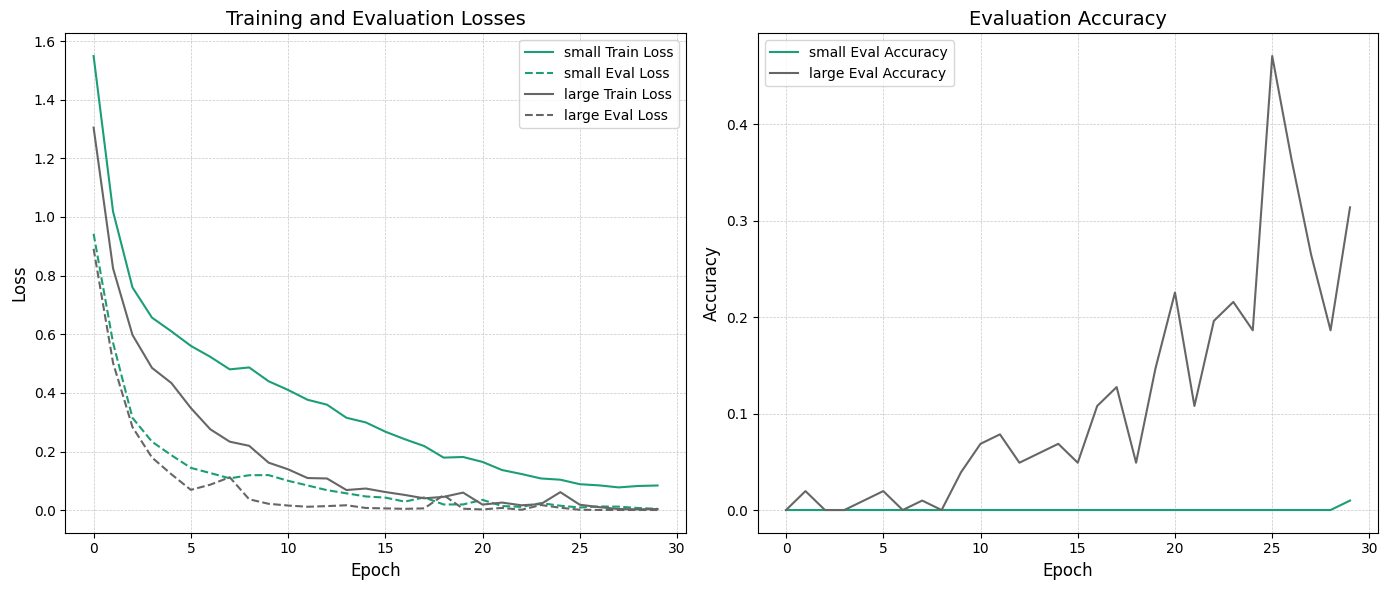

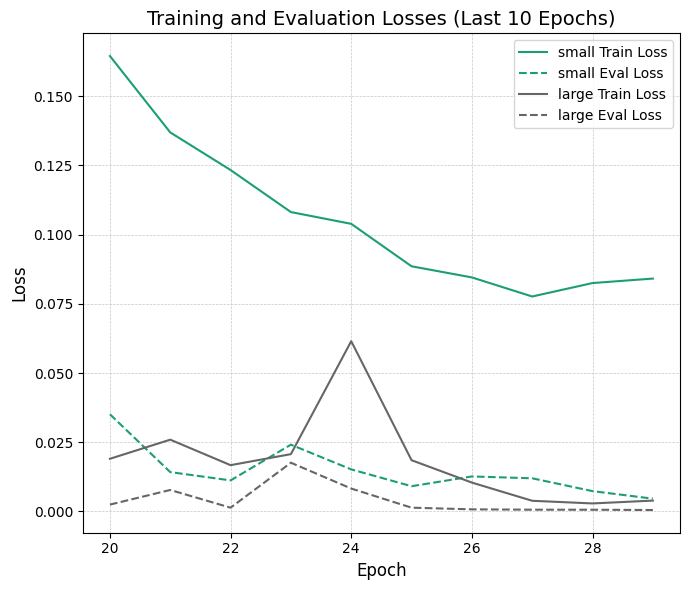

In [ ]:
def collate_fn(batch):
    """
    Custom collate function to process batches for DataLoader.

    Args:
        batch (list of tuples): A batch of (number, roman numeral) pairs.

    Returns:
        tuple: A tuple of tokenized Arabic numbers and Roman numerals.
    """
    # Initialize tokenizers
    arabic_tokenizer = ArabicNumberTokenizer()
    roman_tokenizer = RomanNumeralTokenizer()

    # Unzip the batch
    numbers, romans = zip(*batch)

    # Get max length for padding (add 1 for EOS token)
    max_length = max(len(r) for r in romans) + 1

    # Tokenize all items in batch
    number_tokens = torch.stack([arabic_tokenizer.encode(n) for n in numbers])
    roman_tokens = torch.stack([roman_tokenizer.encode(r, max_length) for r in romans])

    return number_tokens, roman_tokens

def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Perform one epoch of training.

    Args:
        model (nn.Module): Model to train.
        dataloader (DataLoader): Dataloader for the training data.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        device (torch.device): Device for training (CPU or GPU).

    Returns:
        float: Average training loss for the epoch.
    """
    model.train()
    total_loss = 0

    """
    HINTS for each TODO:

    1. Create the mask:
    - Need to identify which positions are not padding tokens

    2. Apply the mask:
    - Use the mask to select only non-padding positions from output and target
    - Make sure output and target shapes match after masking
    """

    roman_tokenizer = RomanNumeralTokenizer()
    pad_idx = roman_tokenizer.pad_idx()

    with tqdm(dataloader, desc="Training", leave=False) as pbar:
        for src, tgt in pbar:
            src, tgt = src.to(device), tgt.to(device)

            optimizer.zero_grad()
            output = model(src, tgt)

            # Reshape output and target for loss calculation
            output = output.view(-1, output.shape[-1])
            target = tgt.view(-1)

            # TODO 3: Calculate loss only on non-padding tokens
            # TODO 3.1: Create mask for selecting only non-padding tokens
            # mask = ...
            mask = target != pad_idx

            # TODO 3.2: Select output based on mask
            # output =
            output = output[mask]

            # TODO 3.3: Select target based on mask
            # target = ...
            target = target[mask]

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix({"Batch Loss": loss.item()})

    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    """
    Evaluate the model with full sample accuracy and token-level loss displayed in tqdm.

    Args:
        model (nn.Module): Model to evaluate.
        dataloader (DataLoader): Dataloader for evaluation data.
        criterion (nn.Module): Loss function.
        device (torch.device): Device for evaluation (CPU or GPU).

    Returns:
        tuple: Average evaluation loss and full sample accuracy.
    """

    roman_tokenizer = RomanNumeralTokenizer()
    pad_idx = roman_tokenizer.pad_idx()
    eos_idx = roman_tokenizer.eos_idx()

    """
    1. Decoding predictions and targets:
    - Use roman_tokenizer.decode() for both
    - Remember that decode() handles EOS and padding tokens automatically
    - Correct accuracy, where accuracy is defined by a full match between the expected roman numeral and the predicted one

    2. Model predictions with teacher forcing:
    - Use model's forward method with src and tgt
    - Remember to properly mask out in order to ignore padding tokens
    - Remember to reshape for loss calculation
    """

    model.eval()
    total_loss = 0
    correct_samples = 0
    total_samples = 0

    with tqdm(dataloader, desc="Evaluating", leave=False) as pbar:
        with torch.no_grad():
            for src, tgt in pbar:
                src, tgt = src.to(device), tgt.to(device)

                # Generate sequences without teacher forcing
                predictions = model.generate(src)

                # Compare full sequences for accuracy
                for i, (pred, target) in enumerate(zip(predictions, tgt)):

                    # Decode both predictions and targets for comparison
                    pred_decoded = roman_tokenizer.decode(pred)
                    target_decoded = roman_tokenizer.decode(target)

                    # Increment accuracy counters
                    if pred_decoded == target_decoded:
                        correct_samples += 1
                    total_samples += 1

                    # If it's the last sample in the batch, print details
                    if i == len(predictions) - 1:
                        print(f"Generated: {pred_decoded}, Expected: {target_decoded}")

                # For loss calculation, use teacher forcing

                # Get model output for current (src, tgt)
                output = model(src, tgt)

                # Flatten output and target
                # [batch_size, tgt_len, vocab_size] -> [batch_size * tgt_len, vocab_size]
                output_flat = output.view(-1, output.shape[-1])

                # [batch_size, tgt_len] -> [batch_size * tgt_len]
                target_flat = tgt.view(-1)


                # Create mask for selecting only non-padding tokens
                mask = (target_flat != pad_idx)

                # Select output based on mask
                output_flat = output_flat[mask]

                # Select target based on mask
                target_flat = target_flat[mask]

                loss = criterion(output_flat, target_flat)
                total_loss += loss.item()
                pbar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / len(dataloader)
    full_sample_accuracy = correct_samples / total_samples if total_samples > 0 else 0
    return avg_loss, full_sample_accuracy


def plot_metrics(metrics_list, metric_names, zoom_epochs=10):
    """
    Plot multiple metrics from different runs in two separate figures:
    1. Full metrics plot (train/eval loss and eval accuracy).
    2. A separate plot focusing on the last `zoom_epochs` of training and evaluation losses.

    Args:
        metrics_list (list of dict): List of metrics dictionaries, each containing "train_losses",
                                     "eval_losses", and "eval_accuracies".
        metric_names (list of str): Names for each run to include in the legend.
        zoom_epochs (int): Number of final epochs to zoom in on for the second figure.
    """
    colors = cm.get_cmap('Dark2', len(metrics_list))

    # Determine maximum epochs and zoomed range
    max_epochs = len(metrics_list[0]["train_losses"])
    start_epoch = max(0, max_epochs - zoom_epochs)
    epoch_range = range(start_epoch, max_epochs)

    # --- Figure 1: Full metrics ---
    fig1, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot losses (full range)
    for i, (metrics, name) in enumerate(zip(metrics_list, metric_names)):
        color = colors(i)
        ax_loss.plot(metrics["train_losses"], label=f'{name} Train Loss', linestyle='-', color=color)
        ax_loss.plot(metrics["eval_losses"], label=f'{name} Eval Loss', linestyle='--', color=color)
    ax_loss.set_xlabel('Epoch', fontsize=12)
    ax_loss.set_ylabel('Loss', fontsize=12)
    ax_loss.set_title('Training and Evaluation Losses', fontsize=14)
    ax_loss.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax_loss.legend(fontsize=10)

    # Plot accuracies (full range)
    for i, (metrics, name) in enumerate(zip(metrics_list, metric_names)):
        color = colors(i)
        ax_acc.plot(metrics["eval_accuracies"], label=f'{name} Eval Accuracy', linestyle='-', color=color)
    ax_acc.set_xlabel('Epoch', fontsize=12)
    ax_acc.set_ylabel('Accuracy', fontsize=12)
    ax_acc.set_title('Evaluation Accuracy', fontsize=14)
    ax_acc.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax_acc.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

    # --- Figure 2: Zoomed in on the last zoom_epochs ---
    fig2, ax_zoom = plt.subplots(figsize=(7, 6))
    for i, (metrics, name) in enumerate(zip(metrics_list, metric_names)):
        color = colors(i)
        ax_zoom.plot(epoch_range, [metrics["train_losses"][e] for e in epoch_range],
                     label=f'{name} Train Loss', linestyle='-', color=color)
        ax_zoom.plot(epoch_range, [metrics["eval_losses"][e] for e in epoch_range],
                     label=f'{name} Eval Loss', linestyle='--', color=color)
    ax_zoom.set_xlabel('Epoch', fontsize=12)
    ax_zoom.set_ylabel('Loss', fontsize=12)
    ax_zoom.set_title(f'Training and Evaluation Losses (Last {zoom_epochs} Epochs)', fontsize=14)
    ax_zoom.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax_zoom.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

def train_model(config, train_dataloader, eval_dataloader, device):
    """
    Train the model for a given number of epochs and return the trained model and metrics.

    Args:
        config (dict): Configuration dictionary with the following keys:
            - num_epochs (int): Number of epochs to train.
            - learning_rate (float): Learning rate for the optimizer.
            - embedding_dim (int): Dimension of embeddings.
            - hidden_size (int): Hidden size of GRU layers.
            - num_layers (int): Number of GRU layers.
            - dropout (float): Dropout rate for GRU layers.
        train_dataloader (DataLoader): Dataloader for training data.
        eval_dataloader (DataLoader): Dataloader for evaluation data.
        device (torch.device): Device for training (CPU or GPU).

    Returns:
        model (nn.Module): Trained model.
        metrics (dict): A dictionary containing training and evaluation losses and accuracies.
    """
    # Initialize tokenizers
    arabic_tokenizer = ArabicNumberTokenizer()
    roman_tokenizer = RomanNumeralTokenizer()

    # Create model
    model = NumberEncoderDecoder(
        arabic_vocab_size=arabic_tokenizer.vocab_size(),
        roman_vocab_size=roman_tokenizer.vocab_size(),
        embedding_dim=config["embedding_dim"],
        hidden_size=config["hidden_size"],
        num_layers=config["num_layers"],
        dropout=config["dropout"]
    ).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=roman_tokenizer.pad_idx())
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

    train_losses = []
    eval_losses = []
    eval_accuracies = []
    best_eval_accuracy = 0

    for epoch in range(1, config["num_epochs"] + 1):
        print(f'Epoch {epoch}/{config["num_epochs"]}')

        # Train for one epoch
        train_loss = train_epoch(model, train_dataloader, criterion, optimizer, device)
        train_losses.append(train_loss)

        # Evaluate the model
        eval_loss, eval_accuracy = evaluate(model, eval_dataloader, criterion, device)
        eval_losses.append(eval_loss)
        eval_accuracies.append(eval_accuracy)

        print(f'Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_accuracy:.4f}')

        # Save the best model
        if eval_accuracy > best_eval_accuracy:
            best_eval_accuracy = eval_accuracy
            torch.save(model.state_dict(), f'model_best.pt')
            print('Model checkpoint saved!')

    # Return the trained model and metrics
    metrics = {
        "train_losses": train_losses,
        "eval_losses": eval_losses,
        "eval_accuracies": eval_accuracies
    }
    return model, metrics

# Define the configuration dictionary
small_model_config = {
    "num_epochs": 30,
    "learning_rate": 0.001,
    "embedding_dim": 16,
    "hidden_size": 32,
    "num_layers": 2,
    "dropout": 0.1
}

large_model_config = {
    "num_epochs": 30,
    "learning_rate": 0.001,
    "embedding_dim": 32,
    "hidden_size": 64,
    "num_layers": 4,
    "dropout": 0.1
}

# Parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16

# Create train and eval datasets
train_dataset, eval_dataset = create_splits(start=1, end=2025, split_ratio=0.95, shuffle=True)


# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,  shuffle=True, collate_fn=collate_fn)

eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Train the model
trained_model, metrics = train_model(config=small_model_config, train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, device=device)
trained_model_s, metrics_s = train_model(config=large_model_config, train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, device=device)


# Plot metrics
plot_metrics([metrics, metrics_s], ['small', 'large'])